In [31]:
# @title Setting Up
from google.colab import drive
drive.mount('/content/drive')

!pip install -q plotly
!pip install -q pandas
!pip install -q scikit-learn==1.3.0
!pip install wordcloud==1.8.2.2

import pandas as pd
import numpy as np
import plotly.express as px
import warnings
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/My Drive/Customer-SA-Quantuva/reviewsLargewithSentiment.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# @title Sampling
desired_proportions = {
    'Jeevansathi': 0.34,
    'Shaadi': 0.33,
    'BharatMatrimony': 0.33
}


def stratified_sampling(df, feature, proportions, n):
    # Create a DataFrame to store the sample
    sample_df = pd.DataFrame(columns=df.columns)

    # Get the list of strata in the desired proportions
    strata = list(proportions.keys())

    # Calculate the desired sample size for each stratum
    sample_sizes = {k: int(n * proportions[k]) for k in strata}

    # Adjust sample sizes to ensure the total matches n
    total_sample_size = sum(sample_sizes.values())
    if total_sample_size < n:
        # Distribute the remaining sample size to the strata
        remaining = n - total_sample_size
        for k in strata:
            sample_sizes[k] += 1
            remaining -= 1
            if remaining <= 0:
                break

    # Sample from the DataFrame for each stratum
    for stratum, size in sample_sizes.items():
        if size > 0:
            stratum_df = df[df[feature] == stratum]
            if len(stratum_df) >= size:
                sampled_stratum_df = stratum_df.sample(size)
            else:
                sampled_stratum_df = stratum_df
            sample_df = pd.concat([sample_df, sampled_stratum_df])

    return sample_df

# Apply stratified sampling
sample = stratified_sampling(df, 'appName', desired_proportions, 0.37*len(df))



In [33]:
# @title Data Snapshot
df = sample.reset_index(drop=True)

df.index+=1

from datetime import datetime
# Tell pandas the existing format of your dates
df['at'] = pd.to_datetime(df['at'], format='%d-%m-%Y')
df

,appName,reviewText,ratings,at,sentiment,sentimentScore
1,Jeevansathi,Such a very good app I like this,5,2023-07-11,positive,0.85
2,Jeevansathi,Its excellent n superb.,5,2024-02-28,positive,0.76
3,Jeevansathi,Excellent aap download and use,5,2024-07-23,positive,0.80
4,Jeevansathi,Bad experience Showing very limited profiles,1,2023-11-28,neutral,0.49
5,Jeevansathi,The app is amazing just dont understand 1 thin...,5,2024-01-24,neutral,0.58
...,...,...,...,...,...,...
15523,BharatMatrimony,"App is very very slow, lags every time.",1,2023-01-01,positive,0.62
15524,BharatMatrimony,"They have full access to your profile, today, ...",1,2023-01-01,negative,0.10
15525,BharatMatrimony,good,3,2023-01-01,positive,0.75
15526,BharatMatrimony,best application,5,2023-01-01,positive,0.76


In [34]:
df.to_csv('/content/drive/My Drive/Customer-SA-Quantuva/sample.csv',
          index=False)

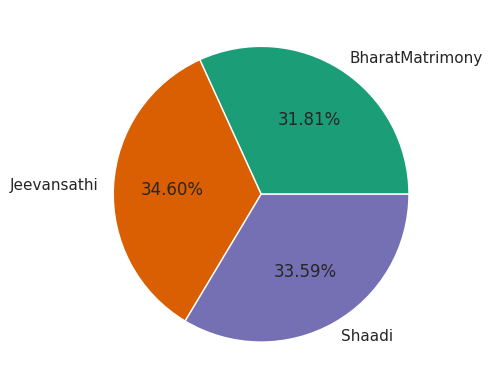

In [35]:
# @title App Data Distribution
from matplotlib import pyplot as plt
import seaborn as sns

# Calculate percentages
data = df.groupby('appName').size()
percentages = data / data.sum() * 100

# Plot pie chart with percentages
ax = data.plot(kind='pie', autopct=lambda pct: f'{pct:.2f}%',
               colors=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

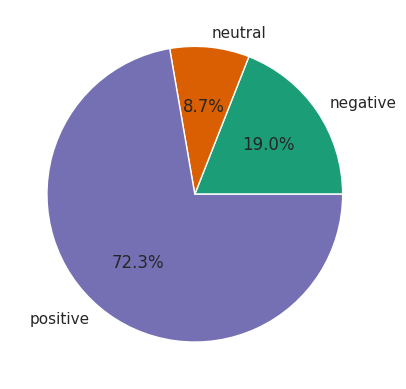

In [36]:
# @title Sentiment
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sentiment').size().plot(kind='pie', autopct='%1.1f%%', colors=sns.palettes.mpl_palette('Dark2'))
plt.ylabel('') # to remove the y-axis label
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Overall Sentiment = 62.65% (Positive)**

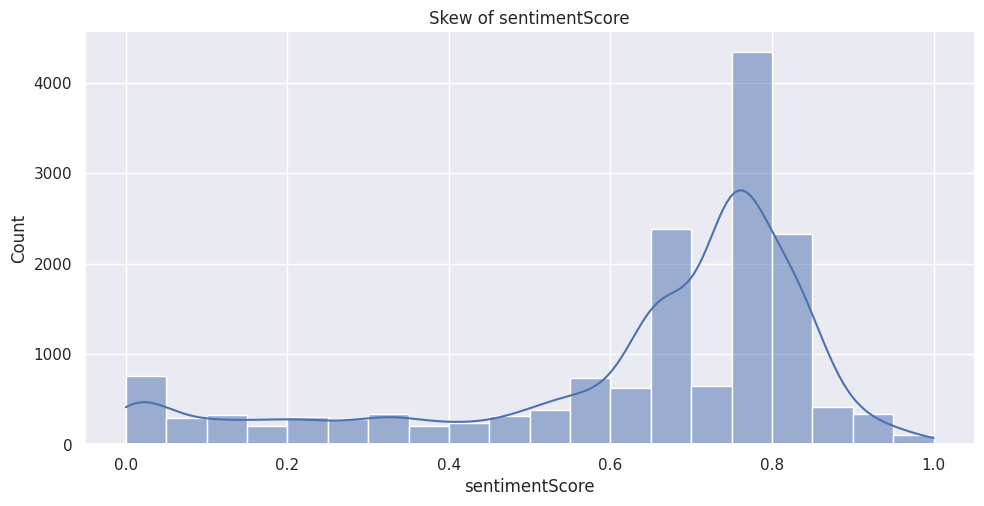

In [37]:
# @title sentimentScore

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.displot(df, x="sentimentScore",
            kind="hist",
            bins=20,
            height=5,
            aspect=2,
            fill=True,
            kde=True);

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Skew of sentimentScore');

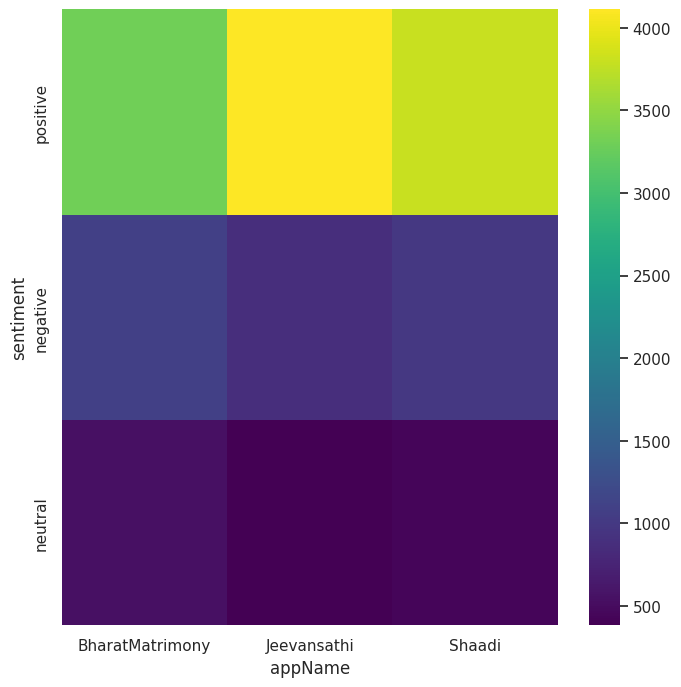

In [38]:
# @title appName vs sentiment

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sentiment'].value_counts()
    for x_label, grp in df.groupby('appName')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('appName')
_ = plt.ylabel('sentiment')

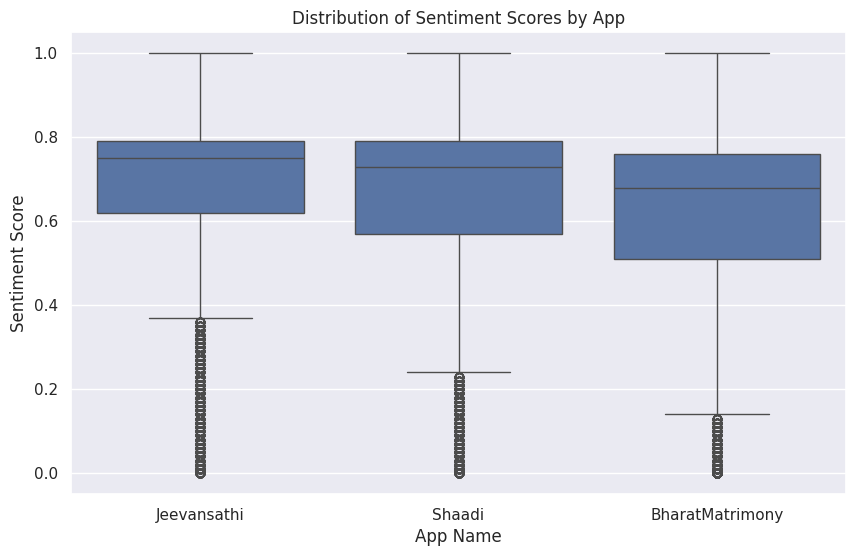

In [39]:
# @title Distribution of Sentiment Scores by App

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.boxplot(x='appName', y='sentimentScore', data=df)
plt.xlabel('App Name')
plt.ylabel('Sentiment Score')
_ = plt.title('Distribution of Sentiment Scores by App')

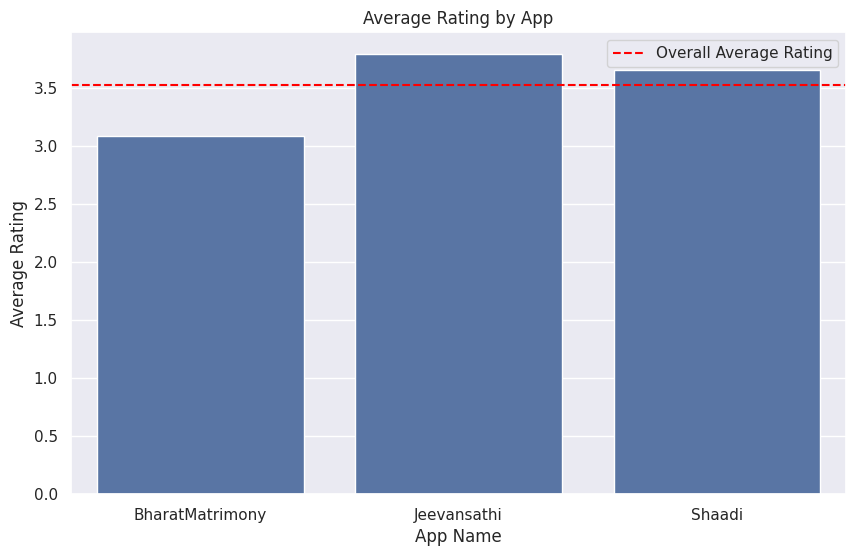

In [40]:
# @title Avg Ratings by App
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average ratings by app
avg_ratings_by_app = df.groupby('appName')['ratings'].mean()

# Calculate overall average rating
overall_avg_rating = df['ratings'].mean()

# Create bar plot for average ratings by app
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_ratings_by_app.index, y=avg_ratings_by_app.values)
plt.xlabel('App Name')
plt.ylabel('Average Rating')
plt.title('Average Rating by App')

# Add dotted line for overall average rating
plt.axhline(y=overall_avg_rating, linestyle='--', color='red', label='Overall Average Rating')
plt.legend()

plt.show()

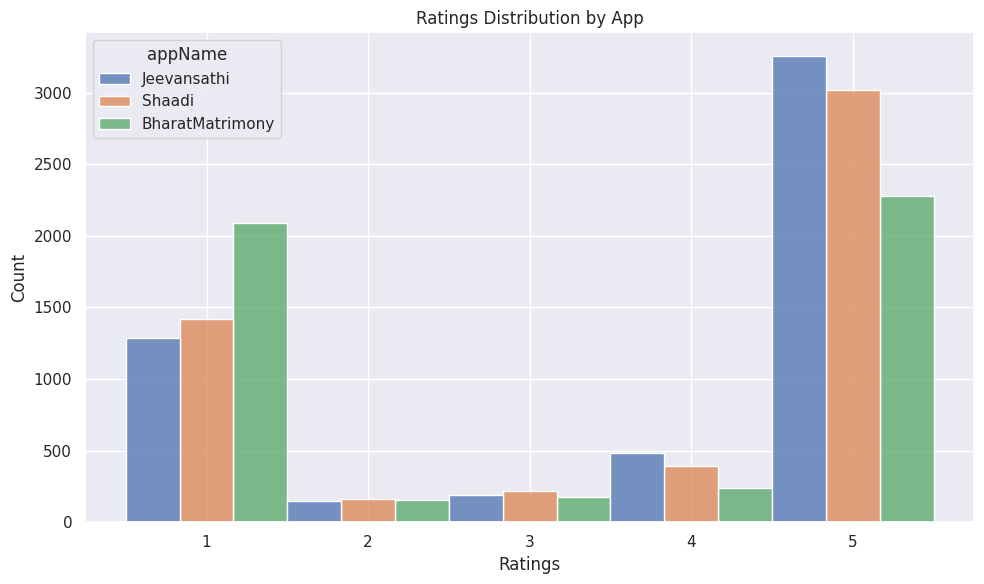

In [41]:
# @title Review Score Distribution by App

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='ratings', hue='appName', multiple='dodge', discrete=True)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Ratings Distribution by App')
plt.xticks(range(1, 6))
_ = plt.tight_layout()

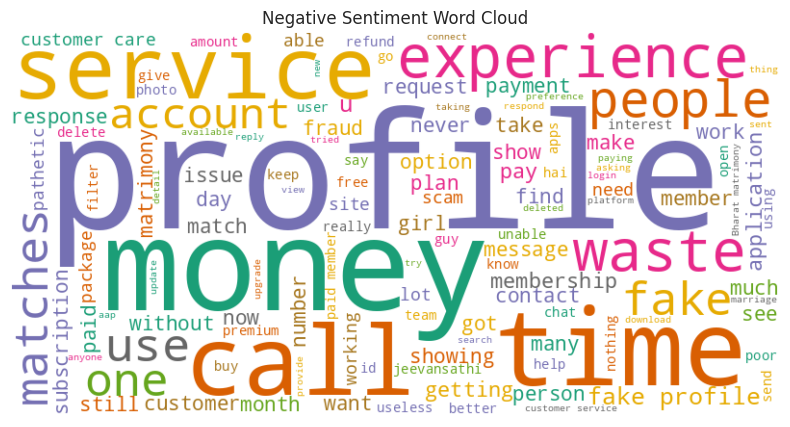

In [44]:
# @title WordCloud

from wordcloud import WordCloud


# Add more stopwords as needed
stopwords = set(STOPWORDS)
stopwords.update(["app", "good", "bad",'even',
                  'worst','will','please', "great"]) # Customize with more irrelevant words


negative_text = " ".join(df[df['sentiment'] == 'negative']['reviewText'].astype(str))

negative_wordcloud = WordCloud(width=800, height=400,
                               background_color='white',
                               stopwords=stopwords,
                               min_font_size=10,
                               colormap='Dark2').generate(negative_text)

# Display word clouds

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Sentiment Word Cloud")
plt.show()